In [220]:
import gc
import re
import string
import operator
from collections import defaultdict
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import keras
import keras_nlp
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.ticker import MaxNLocator
import tokenization
from wordcloud import STOPWORDS
import spacy
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import BatchNormalization, Embedding, Bidirectional, Dense, Input, Dropout, GlobalAveragePooling1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.regularizers import l2


print("TensorFlow version:", tf.__version__)
print("KerasNLP version:", keras_nlp.__version__)

TensorFlow version: 2.18.0
KerasNLP version: 0.19.2


## Kaggle competition: Natural Language Processing with Disaster Tweets
### Project Description
Given X is an important channel for communicating times of emergency, the goal of this project is to build a machine learning model that predicts which tweets are about real disasters and which aren't.  The models will be evaluated on F1 between predicted and expected answers.

### Data Description
Below is a breakdown of the dataset provided.  The project desciption on Kaggle states that 10000 tweets are provided.  When looking at the breakdown below, it appears the training set contains 7613 tweets, while the test set has 3263 tweets.  Examples of tweets have been printed below, to give an idea of the format and content of each data point.  The dataset includes the transcript of the tweet, along with a coresponding keyword and location included for some values in each set.  Target is 1 if a real disaster, 0 in not a disaster.

A. Howard, devrishi, P. Culliton, and Y. Guo, “Natural language pro-
cessing with disaster tweets,” https://kaggle.com/competitions/nlp-getti
ng-started, 2019, kaggle.

In [18]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

print('Training Set Shape = {}'.format(df_train.shape))
print('Training Set Memory Usage = {:.2f} MB'.format(df_train.memory_usage().sum() / 1024**2))
print('Test Set Shape = {}'.format(df_test.shape))
print('Test Set Memory Usage = {:.2f} MB'.format(df_test.memory_usage().sum() / 1024**2))

Training Set Shape = (7613, 5)
Training Set Memory Usage = 0.29 MB
Test Set Shape = (3263, 4)
Test Set Memory Usage = 0.10 MB


In [19]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [20]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


### Exploratory Data Analysis
First balance among target labels will be checked:

/var/folders/wq/s_5l0drd5h57xdjl48dbt_h00000gn/T/ipykernel_52995/2881506209.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(['Not Disaster (4342)', 'Disaster (3271)'])


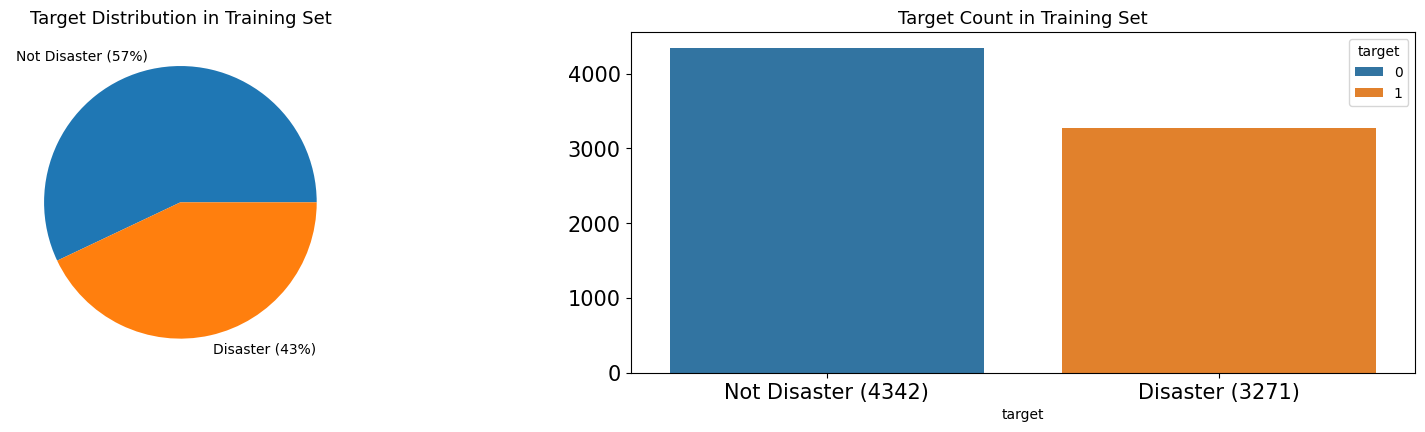

In [45]:
fig, axes = plt.subplots(ncols=2, figsize=(17, 4), dpi=100)
plt.tight_layout()

df_train.groupby('target').count()['id'].plot(kind='pie', ax=axes[0], labels=['Not Disaster (57%)', 'Disaster (43%)'])
sns.countplot(x=df_train['target'], hue=df_train['target'], ax=axes[1])

axes[0].set_ylabel('')
axes[1].set_ylabel('')
axes[1].set_xticklabels(['Not Disaster (4342)', 'Disaster (3271)'])
axes[0].tick_params(axis='x', labelsize=15)
axes[0].tick_params(axis='y', labelsize=15)
axes[1].tick_params(axis='x', labelsize=15)
axes[1].tick_params(axis='y', labelsize=15)

axes[0].set_title('Target Distribution in Training Set', fontsize=13)
axes[1].set_title('Target Count in Training Set', fontsize=13)

plt.show();


Class distributions are equally distributed, so stratification by target is not necessary in cross-validation.

As shown in the output below, the train and test tweets are very similar in length.  

In [21]:
df_train["length"] = df_train["text"].apply(lambda x : len(x))
df_test["length"] = df_test["text"].apply(lambda x : len(x))

print("Train Length Stat")
print(df_train["length"].describe())
print()

print("Test Length Stat")
print(df_test["length"].describe())

Train Length Stat
count    7613.000000
mean      101.037436
std        33.781325
min         7.000000
25%        78.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: length, dtype: float64

Test Length Stat
count    3263.000000
mean      102.108183
std        33.972158
min         5.000000
25%        78.000000
50%       109.000000
75%       134.000000
max       151.000000
Name: length, dtype: float64


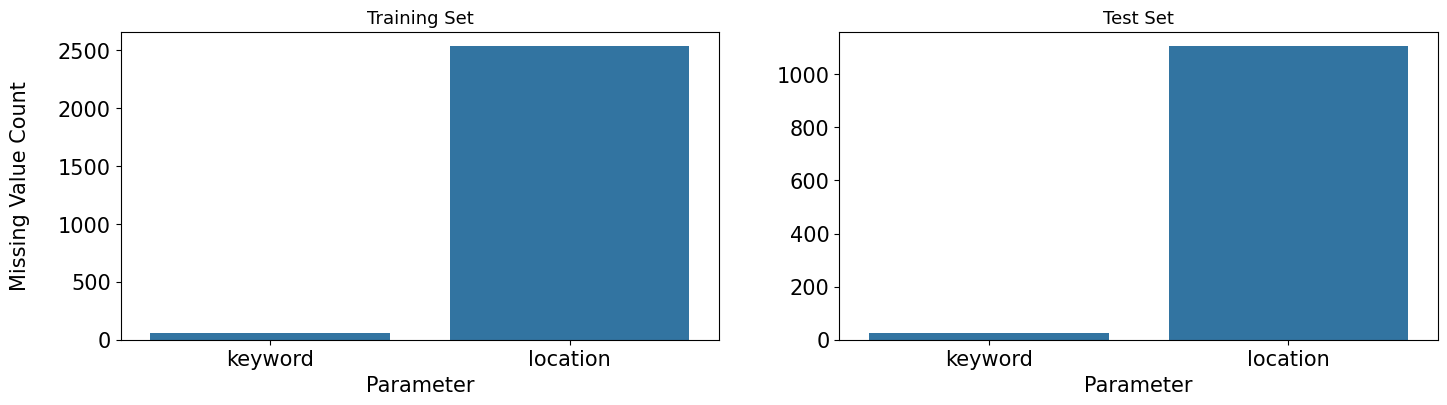

In [22]:
missing_cols = ['keyword', 'location']

fig, axes = plt.subplots(ncols=2, figsize=(17, 4), dpi=100)

sns.barplot(x=df_train[missing_cols].isnull().sum().index, y=df_train[missing_cols].isnull().sum().values, ax=axes[0])
sns.barplot(x=df_test[missing_cols].isnull().sum().index, y=df_test[missing_cols].isnull().sum().values, ax=axes[1])

axes[0].set_ylabel('Missing Value Count', size=15, labelpad=20)
axes[0].set_xlabel('Parameter', size=15)
axes[1].set_xlabel('Parameter', size=15)
axes[0].tick_params(axis='x', labelsize=15)
axes[0].tick_params(axis='y', labelsize=15)
axes[1].tick_params(axis='x', labelsize=15)
axes[1].tick_params(axis='y', labelsize=15)

axes[0].set_title('Training Set', fontsize=13)
axes[1].set_title('Test Set', fontsize=13)

plt.show()


Training and Test sets also have same ratio of mising values for keyword and location indicators, which indicates that they were probably taken from the same sample.  Missing values in those features will be filled with 'no_keyword' and 'no_location' respectively.

In [ ]:
for df in [df_train, df_test]:
    for col in ['keyword', 'location']:
        df[col] = df[col].fillna(f'no_{col}')

In [23]:
print(f'Number of unique values in keyword = {df_train["keyword"].nunique()} (Training) - {df_test["keyword"].nunique()} (Test)')
print(f'Number of unique values in location = {df_train["location"].nunique()} (Training) - {df_test["location"].nunique()} (Test)')

Number of unique values in keyword = 222 (Training) - 222 (Test)
Number of unique values in location = 3342 (Training) - 1603 (Test)


Examples of values in in location feature include the expected values like "Calgary, AB" and "Nashville, TN" along with others like "hollywoodland", "Norf Carolina" and "Your Sister's Bedroom".  With location missing from 33% of the data points and when it is included it varies widely as what appears to be user input (not geographical location), this feature will be dropped.

With only 0.8% of keywords missing and the exact same number of unique keywords in each set, this seems worth exploring further. There was one keyword 'debris' that only appeared in tweets classified as a real disaster and also one keyword 'aftershock' that only appeared in 0 labeled tweets.  The other keywords seem to vary in distribution by target.  This seems to be a valuable feature! Below is a visual of the findings.

In [31]:
df_train['target_mean'] = df_train.groupby('keyword')['target'].transform('mean')
df_train.to_csv('trainmeta.csv', index=False)

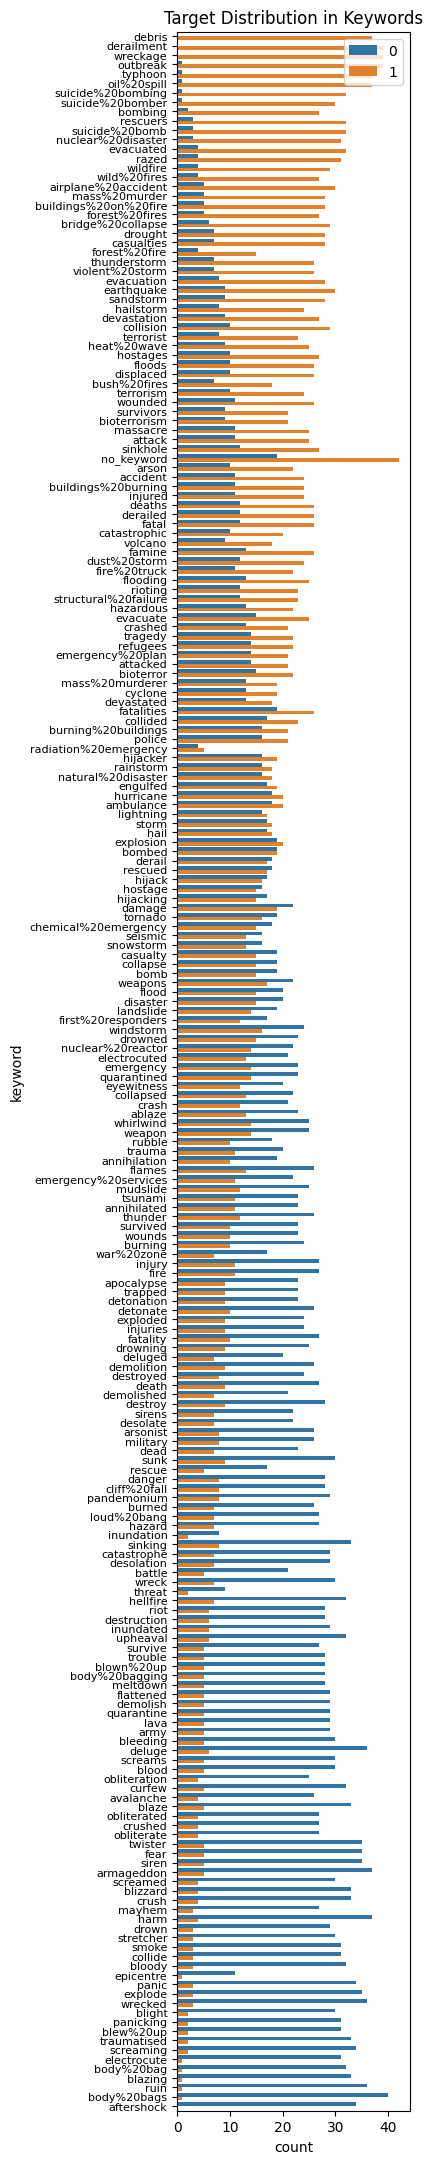

In [28]:
fig = plt.figure(figsize=(3, 27), dpi=100)

sns.countplot(y=df_train.sort_values(by='target_mean', ascending=False)['keyword'],
              hue=df_train.sort_values(by='target_mean', ascending=False)['target'])

plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=8)
plt.legend(loc=1)
plt.title('Target Distribution in Keywords')

plt.show()

df_train.drop(columns=['target_mean'], inplace=True)

Now lets look at some metadata on the tweets included in each set:  word count, unique word count, stop word count, url count, mean word length, char count, punctuation count, hashtag count (#), and mention count (@)

In [40]:
# word_count
df_train['word_count'] = df_train['text'].apply(lambda x: len(str(x).split()))
df_test['word_count'] = df_test['text'].apply(lambda x: len(str(x).split()))

# unique_word_count
df_train['unique_word_count'] = df_train['text'].apply(lambda x: len(set(str(x).split())))
df_test['unique_word_count'] = df_test['text'].apply(lambda x: len(set(str(x).split())))

# stop_word_count
df_train['stop_word_count'] = df_train['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
df_test['stop_word_count'] = df_test['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

# url_count
df_train['url_count'] = df_train['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))
df_test['url_count'] = df_test['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))

# mean_word_length
df_train['mean_word_length'] = df_train['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
df_test['mean_word_length'] = df_test['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# char_count
df_train['char_count'] = df_train['text'].apply(lambda x: len(str(x)))
df_test['char_count'] = df_test['text'].apply(lambda x: len(str(x)))

# punctuation_count
df_train['punctuation_count'] = df_train['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
df_test['punctuation_count'] = df_test['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

# hashtag_count
df_train['hashtag_count'] = df_train['text'].apply(lambda x: len([c for c in str(x) if c == '#']))
df_test['hashtag_count'] = df_test['text'].apply(lambda x: len([c for c in str(x) if c == '#']))

# mention_count
df_train['mention_count'] = df_train['text'].apply(lambda x: len([c for c in str(x) if c == '@']))
df_test['mention_count'] = df_test['text'].apply(lambda x: len([c for c in str(x) if c == '@']))


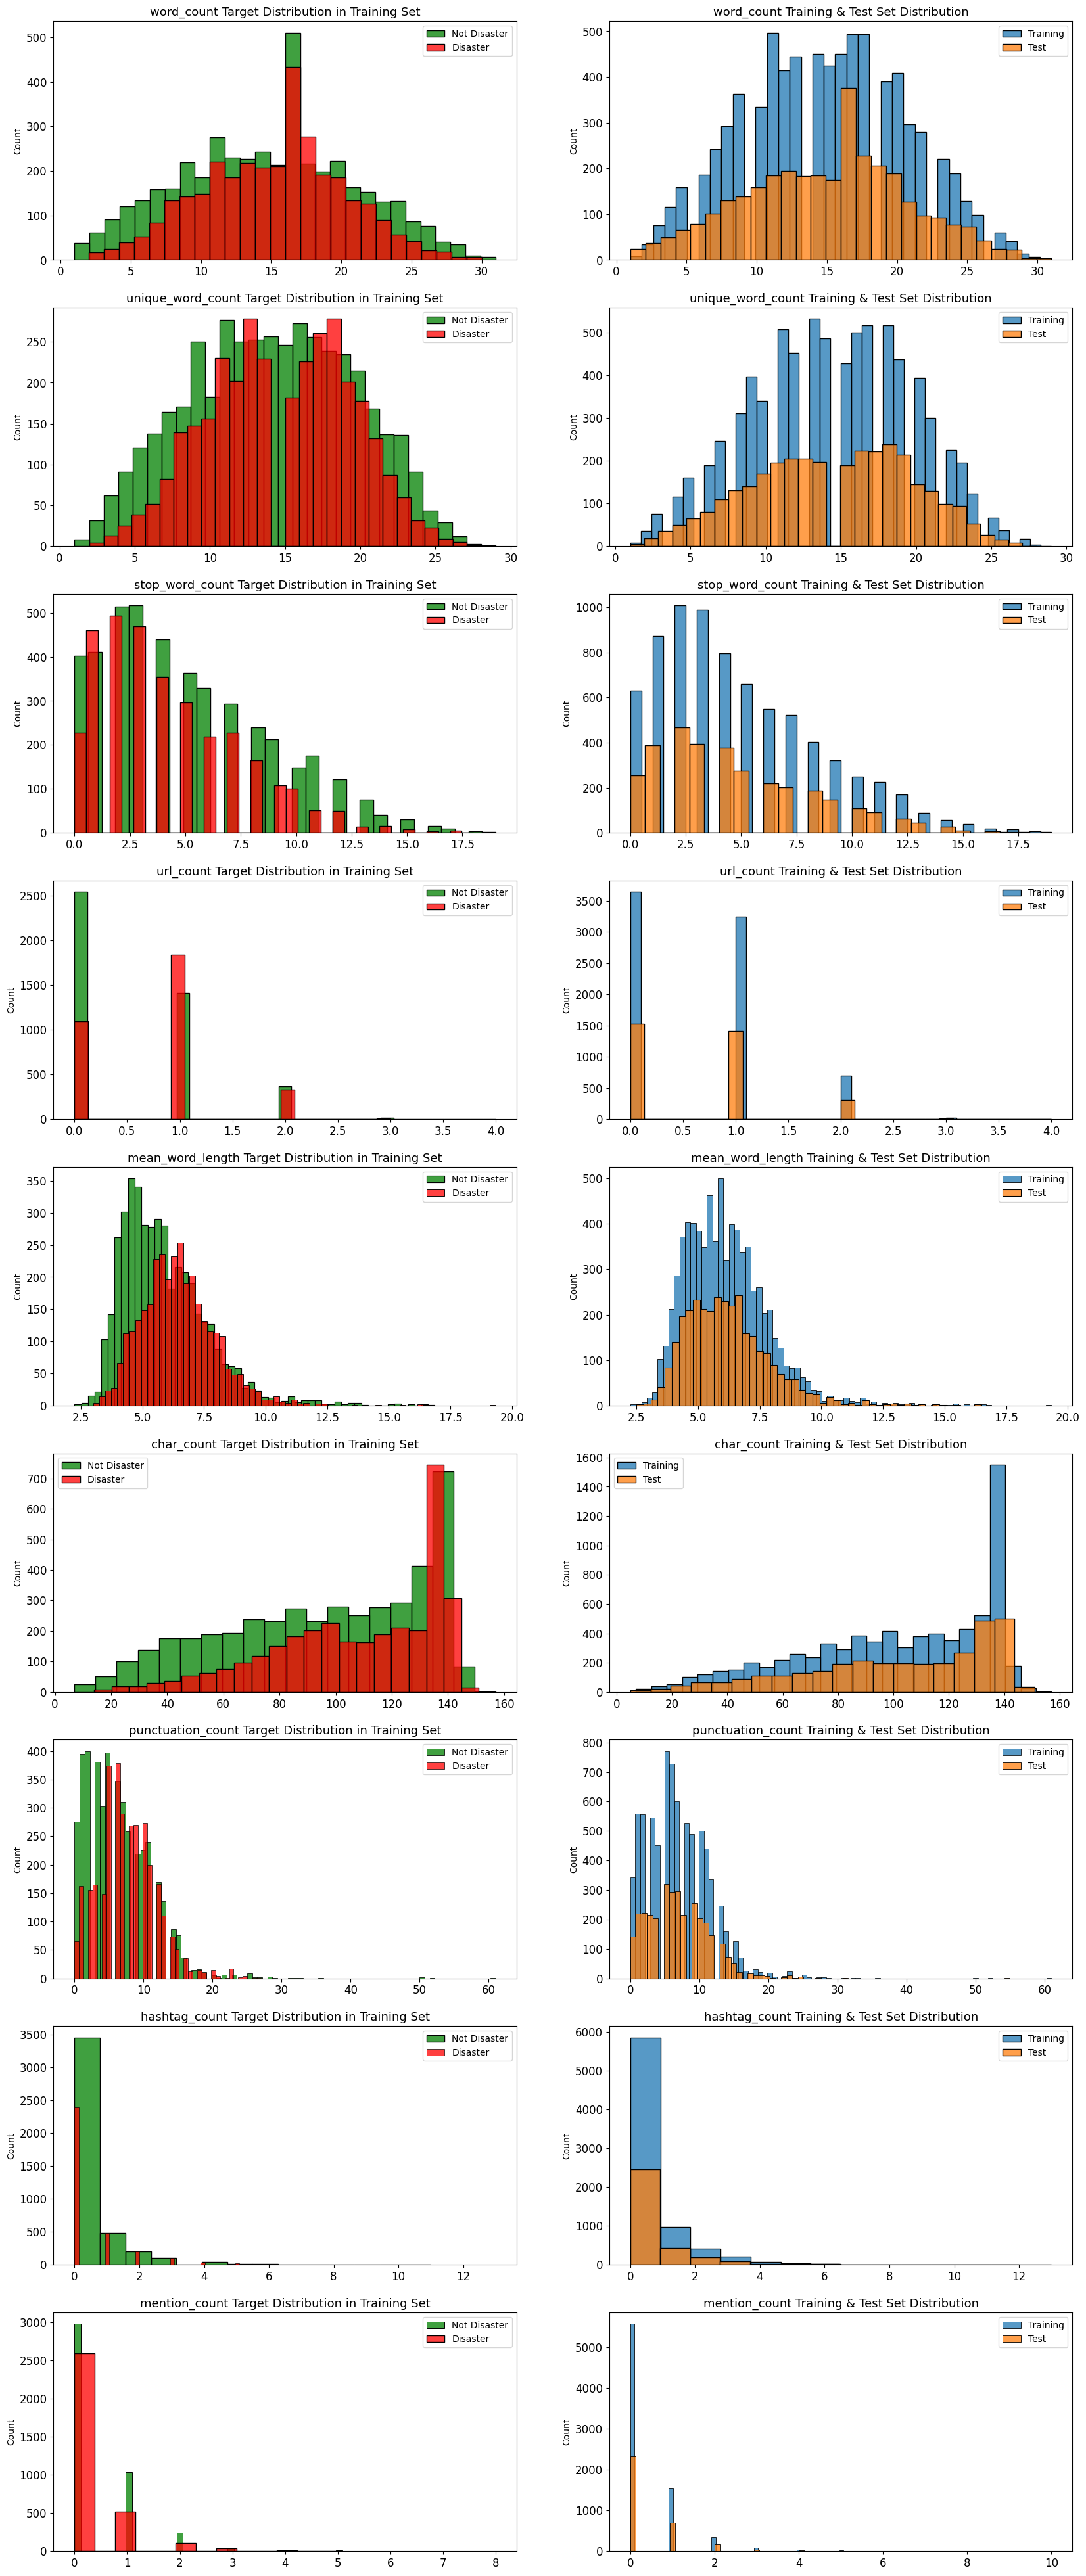

In [43]:
METAFEATURES = ['word_count', 'unique_word_count', 'stop_word_count', 'url_count', 'mean_word_length',
                'char_count', 'punctuation_count', 'hashtag_count', 'mention_count']
DISASTER_TWEETS = df_train['target'] == 1

fig, axes = plt.subplots(ncols=2, nrows=len(METAFEATURES), figsize=(20, 50), dpi=100)

for i, feature in enumerate(METAFEATURES):
    sns.histplot(df_train.loc[~DISASTER_TWEETS][feature], label='Not Disaster', ax=axes[i][0], color='green')
    sns.histplot(df_train.loc[DISASTER_TWEETS][feature], label='Disaster', ax=axes[i][0], color='red')

    sns.histplot(df_train[feature], label='Training', ax=axes[i][1])
    sns.histplot(df_test[feature], label='Test', ax=axes[i][1])
    
    for j in range(2):
        axes[i][j].set_xlabel('')
        axes[i][j].tick_params(axis='x', labelsize=12)
        axes[i][j].tick_params(axis='y', labelsize=12)
        axes[i][j].legend()
    
    axes[i][0].set_title(f'{feature} Target Distribution in Training Set', fontsize=13)
    axes[i][1].set_title(f'{feature} Training & Test Set Distribution', fontsize=13)

plt.show()

In [48]:
df_train['target_mean'] = df_train.groupby('keyword')['target'].transform('mean')
df_train.to_csv('trainmeta.csv', index=False)

The visualizations on the right again confirm that the training and test sets were taken from the same sample.  It appears mean word length, char count, and punctuation count have differing distributions between disaster and non-disaster tweets.  These features may be useful in models.

The text should be cleaned to enhance model performance.

### Text Cleaning
There appear to be lots of punctuation and stop words to clean in this data set. Spacy will be used to get words down to their roots and remove stop words.

In [62]:
def prepare_text_for_model(text):
    #load the english small pipeline without named entity recognition and dependency parser to make model more efficient
    nlp = spacy.load('en_core_web_sm', disable = ['ner', 'parser'])

    #tokenize the text
    doc = nlp(text)

    #use lemmatization to turn words into their root form and eliminate common words (.is_stop) use to reduce size of vocabulary
    tokens = [token.lemma_ for token in doc if not token.is_stop]
    
    #make long str of cleaned text
    clean_text = ' '.join(tokens)
    return clean_text 

Now a new column will be added to both the train and test dataframes containing a copy the original text  and the helper will be applied to text in that column to clean the text.

In [66]:
df_train['clean']=''
df_test['clean']=''

for i in range(df_train.shape[0]):
    df_train.loc[i,'clean']=prepare_text_for_model(df_train.loc[i,'text'])
for j in range(df_test.shape[0]):
    df_test.loc[j,'clean']=prepare_text_for_model(df_test.loc[j,'text'])

df_train.head()

,id,keyword,location,text,target,length,target_mean,word_count,mean_word_length,char_count,punctuation_count,clean
0,1,no_keyword,no_location,Our Deeds are the Reason of this #earthquake M...,1,69,0.688525,13,4.384615,69,1,deed Reason # earthquake ALLAH forgive
1,4,no_keyword,no_location,Forest fire near La Ronge Sask. Canada,1,38,0.688525,7,4.571429,38,1,forest fire near La Ronge Sask . Canada
2,5,no_keyword,no_location,All residents asked to 'shelter in place' are ...,1,133,0.688525,22,5.090909,133,3,resident ask ' shelter place ' notify officer ...
3,6,no_keyword,no_location,"13,000 people receive #wildfires evacuation or...",1,65,0.688525,8,7.125000,65,2,"13,000 people receive # wildfire evacuation or..."
4,7,no_keyword,no_location,Just got sent this photo from Ruby #Alaska as ...,1,88,0.688525,16,4.500000,88,2,get send photo Ruby # Alaska smoke # wildfire ...


During EDA, it was noticed that training and test sets were split from each keyword group.  Each keyword was stratified when creating these sets, so the same will be replicated for cross-validation.  

In [126]:
y = df_train['target']
X = df_train[['clean','keyword']]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=X['keyword'])
X_train['data'] = X_train[['clean', 'keyword']].agg(' '.join, axis=1)
X_val['data'] = X_val[['clean', 'keyword']].agg(' '.join, axis=1)
X_test=df_test[['clean','keyword']]
X_test['data'] = X_test[['clean', 'keyword']].agg(' '.join, axis=1)
X_train = X_train['data']
X_val = X_val['data']
X_test = X_test['data']


/var/folders/wq/s_5l0drd5h57xdjl48dbt_h00000gn/T/ipykernel_52995/3966470461.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['data'] = X_test[['clean', 'keyword']].agg(' '.join, axis=1)


### Analysis: Model Building and Training

#### Model 1:  Pretrained DistilBertClassifier, 66,955,010 Parameters
##### Hyper-parameters: Adam optimizer, lr = 1e-5, batch size = 32, epochs = 2

I am new to RNN modeling so I followed along with the provided kaggle notebook to build my first model.  This model is pretrained.  I first ran this with 5 epochs and it overfit, so final model of this type has 2 epochs.

In [100]:
# Load a DistilBERT model.
preset= "distil_bert_base_en_uncased"

# Pretrained classifier.
classifier = keras_nlp.models.DistilBertClassifier.from_preset(preset,
                                                                
                                                               num_classes=2)

classifier.summary()

Preprocessor: "distil_bert_text_classifier_preprocessor_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ distil_bert_tokenizer (DistilBertTokenizer)                   │                       Vocab size: 30,522 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "distil_bert_text_classifier_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ distil_bert_backbone          │ (None, None, 768)         │      66,362,880 │ padding_mask[0][0],        │
│ (DistilBertBackbone)          │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ get_item_1 (GetItem)          │ (None, 768)               │               0 │ distil_bert_backbone[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pooled_dense (Dense)          │ (None, 768)               │         590,592 │ get_item_1[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ output_dropout (Dropout)      │ (None, 768)               │               0 │ pooled_dense[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ logits (Dense)                │ (None, 2)                 │           1,538 │ output_dropout[0][0]       │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 66,955,010 (255.41 MB)

 Trainable params: 66,955,010 (255.41 MB)

 Non-trainable params: 0 (0.00 B)

In [101]:
# Compile
classifier.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), #'binary_crossentropy',
    optimizer=keras.optimizers.Adam(1e-5),
    metrics= ["accuracy"]  
)

# Fit
history = classifier.fit(x=X_train,
                         y=y_train,
                         batch_size=32,
                         epochs=2, 
                         validation_data=(X_val, y_val)
                        )

Epoch 1/2
191/191 ━━━━━━━━━━━━━━━━━━━━ 330s 2s/step - accuracy: 0.7207 - loss: 0.5602 - val_accuracy: 0.8188 - val_loss: 0.4208
Epoch 2/2
191/191 ━━━━━━━━━━━━━━━━━━━━ 304s 2s/step - accuracy: 0.8392 - loss: 0.3956 - val_accuracy: 0.8247 - val_loss: 0.4102


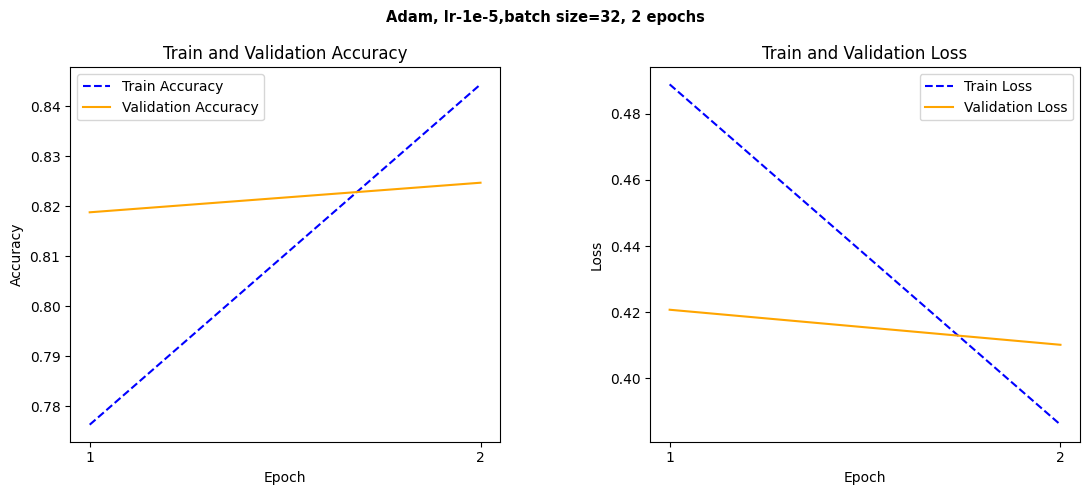

In [105]:
def trainvvalplots(hist, title):
    train_accuracy = hist.history['accuracy']
    validation_accuracy = hist.history['val_accuracy']
    train_loss = hist.history['loss']
    validation_loss = hist.history['val_loss']
            
    epochs = list(range(1, len(train_accuracy)+1))

    figure = plt.figure(figsize=(11, 5))
    figure.suptitle(title, fontsize=10.5, fontweight='bold')

    gs = gridspec.GridSpec(1, 3, width_ratios=[1, 0, 1])

    ax0 = figure.add_subplot(gs[0])
    ax1 = figure.add_subplot(gs[2])

    ax0.plot(epochs, train_accuracy, linestyle='dashed', color='blue', label='Train Accuracy')
    ax0.plot(epochs, validation_accuracy, linestyle='solid', color='orange', label='Validation Accuracy')
    if len(epochs) <= 18:
        ax0.set_xticks(epochs)
    ax0.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax0.set_xlabel('Epoch')
    ax0.set_ylabel('Accuracy')
    ax0.set_title('Train and Validation Accuracy')
    ax0.legend()

    ax1.plot(epochs, train_loss, linestyle='dashed', color='blue', label='Train Loss')
    ax1.plot(epochs, validation_loss, linestyle='solid', color='orange', label='Validation Loss')
    if len(epochs) <= 18:
        ax1.set_xticks(epochs)
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Train and Validation Loss')
    ax1.legend()

    plt.tight_layout()
    plt.show()

trainvvalplots(history, 'Adam, lr-1e-5,batch size=32, 2 epochs')


5 epochs overfit the data.  2 epochs seems better for these hyperparameters.

In [106]:
def displayConfusionMatrix(y_true, y_pred, dataset):
    disp = ConfusionMatrixDisplay.from_predictions(
        y_true,
        np.argmax(y_pred, axis=1),
        display_labels=["Not Disaster","Disaster"],
        cmap=plt.cm.Blues
    )

    tn, fp, fn, tp = confusion_matrix(y_true, np.argmax(y_pred, axis=1)).ravel()
    f1_score = tp / (tp+((fn+fp)/2))

    disp.ax_.set_title("Confusion Matrix on " + dataset + " Dataset -- F1 Score: " + str(f1_score.round(2)))

191/191 ━━━━━━━━━━━━━━━━━━━━ 78s 403ms/step


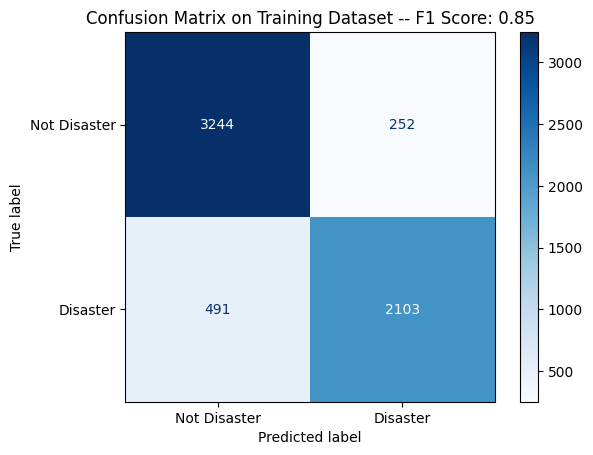

In [107]:
y_pred_train = classifier.predict(X_train)

displayConfusionMatrix(y_train, y_pred_train, "Training")

48/48 ━━━━━━━━━━━━━━━━━━━━ 20s 414ms/step


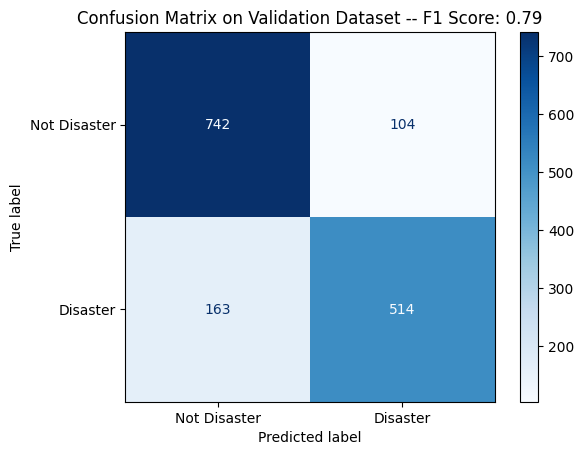

In [108]:
y_pred_val = classifier.predict(X_val)

displayConfusionMatrix(y_val, y_pred_val, "Validation")

In [110]:
sample_submission = pd.read_csv("sample_submission.csv")
sample_submission.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [115]:
sample_submission["target"] = np.argmax(classifier.predict(X_test), axis=1)

sample_submission.to_csv("submission1.csv", index=False)

102/102 ━━━━━━━━━━━━━━━━━━━━ 43s 419ms/step


This model had an F1-Score of 0.82408 on the test data:
<img src="Submission1.png" 
        alt="Submission1" 
        width="800" 
        height="100" 
        style="display: block; margin: 0 auto" />

#### Model 2:  Bidirectional RNN with LSTM
Next I wanted to experiment with LSTM or GRU as was talked about in this week's lectures.  I leaned on Google Gemini for a starting point of a simple model, then gleaned information from a number of models on stack overflow, etc.  to learn how to add the bidirectional layers with LSTM.  This model has 4 layers and around 2.5 mil parameters, most of which come from the embedding of the tweets.

In [189]:
# Tokenization
tokenizer = Tokenizer(num_words=30000) # Consider only top 100 words
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(X_train)
seqval = tokenizer.texts_to_sequences(X_val)
seqtest = tokenizer.texts_to_sequences(X_test)
# Padding
padded_sequences = pad_sequences(sequences, maxlen=100) # Pad sequences to length 160
padseqval = pad_sequences(seqval, maxlen=100)
padseqtest = pad_sequences(seqtest, maxlen=100)
#Model from scratch
model2 = tf.keras.Sequential()
model2.add(Embedding(len(word_index)+1,128, input_length=100))
model2.build((None,101)) # build the Embedding to inilizices the weight
model2.add(Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)))
model2.add(Bidirectional(tf.keras.layers.LSTM(32)))
model2.add(Dense(64, activation='relu'))
model2.add(Dense(1, activation='sigmoid')) # Output layer (sigmoid for binary classification)

 
# Summary of the model
model2.summary()
 
# Compile the model
model2.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001, beta_1=0.9, beta_2=0.99),
    metrics=['accuracy'],
    )



Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_14 (Embedding)        │ (None, 101, 128)       │     2,213,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_28                │ (None, 101, 128)       │        98,816 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_29                │ (None, 64)             │        41,216 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,357,377 (8.99 MB)

 Trainable params: 2,357,377 (8.99 MB)

 Non-trainable params: 0 (0.00 B)

In [190]:
history2 = model2.fit(x = padded_sequences, y = y_train,
                         batch_size=16,
                         epochs=20, 
                         validation_data=(padseqval, y_val))

Epoch 1/15
381/381 ━━━━━━━━━━━━━━━━━━━━ 42s 103ms/step - accuracy: 0.5449 - loss: 0.6906 - val_accuracy: 0.5555 - val_loss: 0.6835
Epoch 2/15
381/381 ━━━━━━━━━━━━━━━━━━━━ 38s 99ms/step - accuracy: 0.5670 - loss: 0.6797 - val_accuracy: 0.5555 - val_loss: 0.6760
Epoch 3/15
381/381 ━━━━━━━━━━━━━━━━━━━━ 39s 102ms/step - accuracy: 0.5769 - loss: 0.6685 - val_accuracy: 0.5555 - val_loss: 0.6686
Epoch 4/15
381/381 ━━━━━━━━━━━━━━━━━━━━ 39s 102ms/step - accuracy: 0.5794 - loss: 0.6590 - val_accuracy: 0.5555 - val_loss: 0.6605
Epoch 5/15
381/381 ━━━━━━━━━━━━━━━━━━━━ 39s 103ms/step - accuracy: 0.5708 - loss: 0.6527 - val_accuracy: 0.5601 - val_loss: 0.6534
Epoch 6/15
381/381 ━━━━━━━━━━━━━━━━━━━━ 39s 103ms/step - accuracy: 0.6038 - loss: 0.6454 - val_accuracy: 0.5936 - val_loss: 0.6433
Epoch 7/15
381/381 ━━━━━━━━━━━━━━━━━━━━ 40s 105ms/step - accuracy: 0.6478 - loss: 0.6343 - val_accuracy: 0.6179 - val_loss: 0.6360
Epoch 8/15
381/381 ━━━━━━━━━━━━━━━━━━━━ 40s 104ms/step - accuracy: 0.6578 - loss: 0.

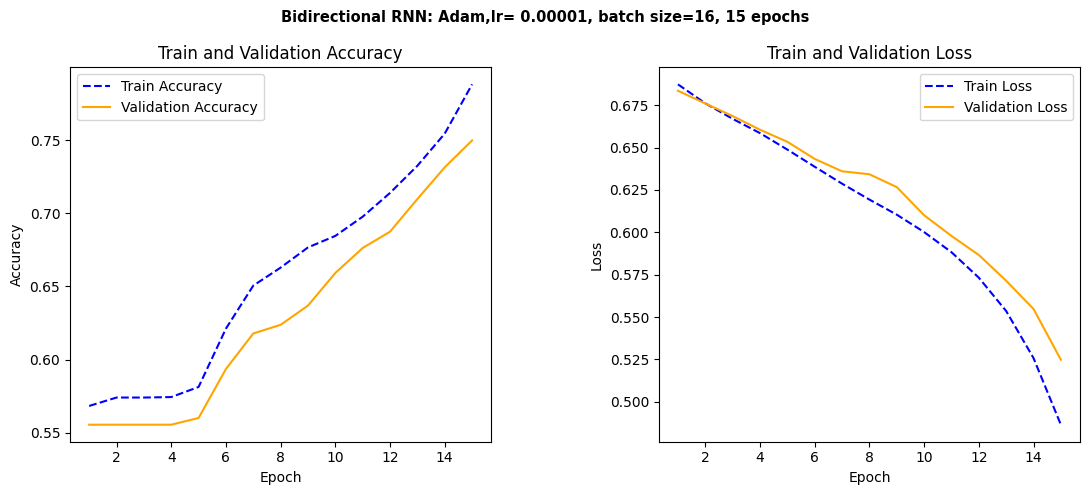

In [195]:
trainvvalplots(history2, 'Bidirectional RNN: Adam,lr= 0.00001, batch size=16, 15 epochs')

In [193]:
target = model2.predict(padseqtest)
output = np.round(target)
output = output.flatten()
output = output.astype(int)
output



102/102 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step


array([0, 0, 1, ..., 1, 1, 0])

In [194]:
sample_submission["target"] = output

sample_submission.to_csv("submission2.csv", index=False)

After a few rounds of hyper-parameter tuning which will be discussed in the conclusion This model had an F1-Score of .7551.  Not as good as the original pretrained model, but also a much smaller model.
<img src="Submission2.png" 
        alt="Submission1" 
        width="800" 
        height="100" 
        style="display: block; margin: 0 auto" />

#### Model 3:  Deepen Model 2
With the much smaller model 2 performing only a bit lower than the huge original model, I wanted to look at how deepening this model would affect perform, with a goal of meeting or surpassing the original model.

In [204]:
model3 = tf.keras.Sequential()
model3.add(Embedding(len(word_index)+1,128, input_length=100))
model3.build((None,101)) # build the Embedding to inilizices the weight
model3.add(Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)))
model3.add(Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)))
model3.add(Bidirectional(tf.keras.layers.LSTM(32)))
model3.add(Dense(64, activation='relu'))
model3.add(Dense(64, activation='relu'))
model3.add(Dense(64, activation='relu'))
model3.add(Dense(1, activation='sigmoid')) # Output layer (sigmoid for binary classification)

# Summary of the model
model3.summary()
 
# Compile the model
model3.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001, beta_1=0.9, beta_2=0.99),
    metrics=['accuracy'])

/Users/sarahpfeifer/Documents/Python Code/.venv/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_19 (Embedding)        │ (None, 101, 128)       │     2,213,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_43                │ (None, 101, 128)       │        98,816 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_44                │ (None, 101, 128)       │        98,816 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_45                │ (None, 64)             │        41,216 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,464,513 (9.40 MB)

 Trainable params: 2,464,513 (9.40 MB)

 Non-trainable params: 0 (0.00 B)

In [205]:
history3 = model3.fit(x = padded_sequences, y = y_train,
                         batch_size=16,
                         epochs=15, 
                         validation_data=(padseqval, y_val))

Epoch 1/15
381/381 ━━━━━━━━━━━━━━━━━━━━ 75s 181ms/step - accuracy: 0.5269 - loss: 0.6915 - val_accuracy: 0.5555 - val_loss: 0.6835
Epoch 2/15
381/381 ━━━━━━━━━━━━━━━━━━━━ 68s 179ms/step - accuracy: 0.5826 - loss: 0.6754 - val_accuracy: 0.5555 - val_loss: 0.6765
Epoch 3/15
381/381 ━━━━━━━━━━━━━━━━━━━━ 70s 184ms/step - accuracy: 0.5771 - loss: 0.6673 - val_accuracy: 0.5555 - val_loss: 0.6666
Epoch 4/15
381/381 ━━━━━━━━━━━━━━━━━━━━ 72s 188ms/step - accuracy: 0.5737 - loss: 0.6577 - val_accuracy: 0.5870 - val_loss: 0.6523
Epoch 5/15
381/381 ━━━━━━━━━━━━━━━━━━━━ 70s 183ms/step - accuracy: 0.6350 - loss: 0.6403 - val_accuracy: 0.6120 - val_loss: 0.6396
Epoch 6/15
381/381 ━━━━━━━━━━━━━━━━━━━━ 70s 185ms/step - accuracy: 0.6569 - loss: 0.6258 - val_accuracy: 0.6316 - val_loss: 0.6303
Epoch 7/15
381/381 ━━━━━━━━━━━━━━━━━━━━ 69s 180ms/step - accuracy: 0.6722 - loss: 0.6144 - val_accuracy: 0.6540 - val_loss: 0.6154
Epoch 8/15
381/381 ━━━━━━━━━━━━━━━━━━━━ 69s 181ms/step - accuracy: 0.6909 - loss: 0

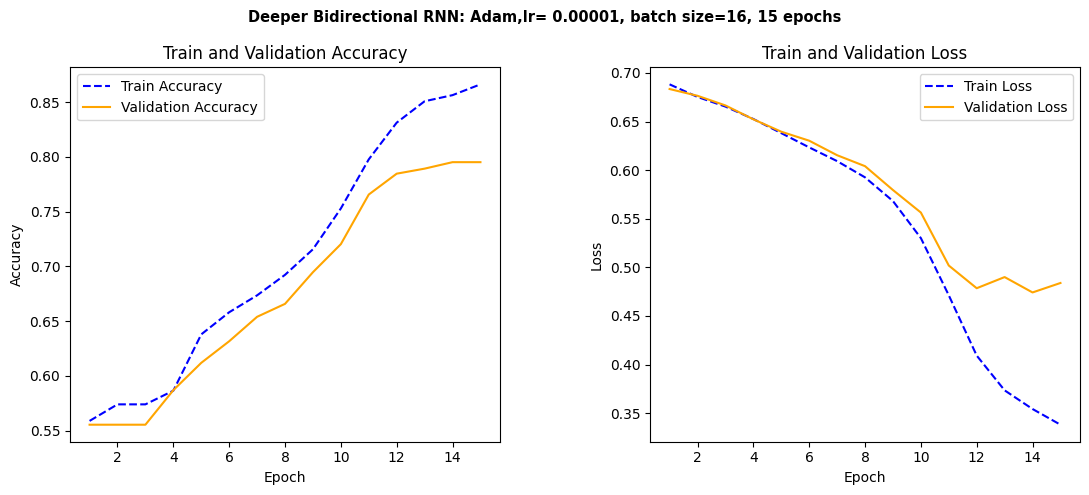

In [207]:
trainvvalplots(history3, 'Deeper Bidirectional RNN: Adam,lr= 0.00001, batch size=16, 15 epochs')

In [208]:
target3 = model3.predict(padseqtest)
output3 = np.round(target3)
output3 = output3.flatten()
output3 = output3.astype(int)

sample_submission["target"] = output3

sample_submission.to_csv("submission3.csv", index=False)

102/102 ━━━━━━━━━━━━━━━━━━━━ 9s 86ms/step


Again, after some hyper-parameter tuning,the deeper model had an F1-Score of .78363.  Still not as good as the original pretrained model, but getting closer with still a much smaller model.
<img src="Submission3.png" 
        alt="Submission1" 
        width="800" 
        height="100" 
        style="display: block; margin: 0 auto" />

#### Model 4:  Adjust architechture and deepen Model 3
With the deeper model 3 overfitting after 12 epochs, but performing only a bit lower than the huge original model, next I will tweak both the architechture of the model to include regularization, as well as add more parameters in an attempt to outperform the initial model. 

In [221]:
model4 = tf.keras.Sequential()
model4.add(Embedding(len(word_index)+1,128, input_length=100))
model4.build((None,101)) # build the Embedding to inilizices the weight
model4.add(Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.01), 
                recurrent_regularizer=tf.keras.regularizers.l2(0.01))))
model4.add(BatchNormalization())
model4.add(Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.01), 
                recurrent_regularizer=tf.keras.regularizers.l2(0.01))))
model4.add(BatchNormalization())
model4.add(Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.01), 
                recurrent_regularizer=tf.keras.regularizers.l2(0.01))))
model4.add(BatchNormalization())
model4.add(Bidirectional(tf.keras.layers.LSTM(32)))
model4.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
model4.add(Dropout(0.5))
model4.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model4.add(Dropout(0.5))
model4.add(Dense(32, activation='relu',kernel_regularizer=l2(0.01)))
model4.add(Dense(1, activation='sigmoid')) # Output layer (sigmoid for binary classification)

# Summary of the model
model4.summary()
 
# Compile the model
model4.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001, beta_1=0.9, beta_2=0.99),
    metrics=['accuracy'])

/Users/sarahpfeifer/Documents/Python Code/.venv/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


TypeError: Dropout.__init__() missing 1 required positional argument: 'rate'

In [218]:
history4 = model4.fit(x = padded_sequences, y = y_train,
                         batch_size=16,
                         epochs=20, 
                         validation_data=(padseqval, y_val))

Epoch 1/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 69s 322ms/step - accuracy: 0.4245 - loss: 16.7398 - val_accuracy: 0.4071 - val_loss: 16.2113
Epoch 2/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 58s 305ms/step - accuracy: 0.3906 - loss: 16.0392 - val_accuracy: 0.3953 - val_loss: 15.5304
Epoch 3/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 59s 307ms/step - accuracy: 0.3844 - loss: 15.3642 - val_accuracy: 0.3716 - val_loss: 14.8724
Epoch 4/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 58s 305ms/step - accuracy: 0.4152 - loss: 14.7115 - val_accuracy: 0.5555 - val_loss: 14.2351
Epoch 5/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 58s 305ms/step - accuracy: 0.5703 - loss: 14.0789 - val_accuracy: 0.5555 - val_loss: 13.6185
Epoch 6/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 58s 303ms/step - accuracy: 0.5723 - loss: 13.4674 - val_accuracy: 0.5555 - val_loss: 13.0226
Epoch 7/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 58s 306ms/step - accuracy: 0.5756 - loss: 12.8760 - val_accuracy: 0.5555 - val_loss: 12.4471
Epoch 8/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 59s 309ms/step - accuracy: 0.

This notebook was created using information from the following websites:
- https://www.kaggle.com/code/alexia/kerasnlp-starter-notebook-disaster-tweets
- https://www.kaggle.com/code/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert
